In [ ]:
!pip install ffmpeg-python
!pip install SpeechRecognition
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio
import cv2
import copy
import time
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import speech_recognition as sr
from IPython.display import Javascript
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write as wav_write
import ffmpeg
import requests, zipfile
import io

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
!git clone https://github.com/j-ka11/ASL_translator_bot.git
nn = tf.keras.models.load_model('/content/ASL_translator_bot/model/')
nn.load_weights('/content/ASL_translator_bot/weights/')

fatal: destination path 'ASL_translator_bot' already exists and is not an empty directory.


In [ ]:
# IMAGE CAPTURING CODE
def predictLetter(imageFileName):
    trainImage = PIL.Image.open('/content/'+imageFileName)
    trainImagePred = []
    trainImagePred.append(np.asarray(trainImage))
    trainImagePred = np.asarray(trainImagePred) / 255
    trainPreds = nn.predict(trainImagePred)
    letterPred = chr(np.argmax(trainPreds[0]) + 65)
    return letterPred

#Video capture code provided by Google Colab
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      div.innerHTML = "Please center hand in the frame and try to maintain a clear background. Click on the console and then press any key to take a picture."

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {window.addEventListener('keypress', resolve)});

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

def doCamera():
  phrase = ""
  while True:
    try:
      filename = take_photo()
      img = cv2.imread(filename, 1)
      x, y, z = img.shape
      y_top = int(y/2)-200
      y_bot = int(y/2)+200
      x_left = int(x/2)-200
      x_right = int(x/2)+200
      img = img[x_left:x_right, y_top:y_bot]
      img = cv2.resize(img, (200, 200))
      cv2.imwrite(filename, img)

      # Show the image which was just taken.
      display(Image(filename))
      # loop = asyncio.get_event_loop()
      # loop.run_until_complete(predict(filename))
      letter = predictLetter(filename)
      if letter == '[':
        break
      elif letter == ']':
        letter = " "
      print(letter)
      phrase += letter
      
    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))
  print(phrase)

In [ ]:
# SPEECH TO TEXT CODE
#code snippets from https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=xuKJ4wBU6gxx 
#and https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be#file-record-py

def record(sec=3):
  RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

  display(Javascript(RECORD))
  s = eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=b)
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))
  wav_write('audio.wav', sr, audio)
  
def speechToText():
  #import library
  # Initialize recognizer class (for recognizing the speech)
  r = sr.Recognizer()
  # Reading Microphone as source
  # listening the speech and store in audio_text variable
  print("Talk")
  a = record()
  audio = sr.AudioFile('audio.wav')

  with audio as source:
    audio_text = r.record(source)

    print("Time over, thanks")
  # recoginize_() method will throw a request error if the API is unreachable, hence using exception handling
  #using google speech recognition
  speech_string = r.recognize_google(audio_text)
  #print("Text: "+speech_string)
  return speech_string

<IPython.core.display.Javascript object>

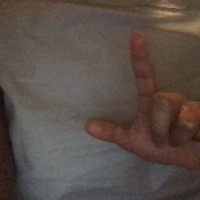

N


<IPython.core.display.Javascript object>

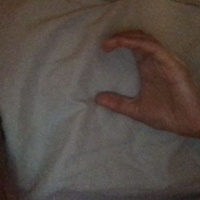

M


<IPython.core.display.Javascript object>

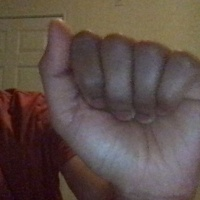

S


<IPython.core.display.Javascript object>

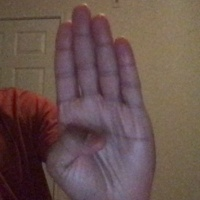

C


<IPython.core.display.Javascript object>

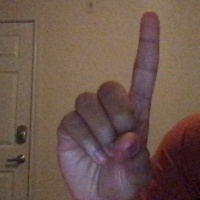

N


<IPython.core.display.Javascript object>

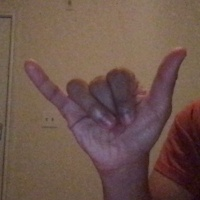

S


<IPython.core.display.Javascript object>

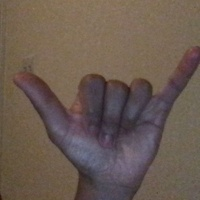

NMSCNS


<IPython.core.display.Javascript object>

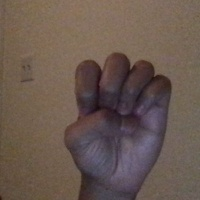

<IPython.core.display.Javascript object>

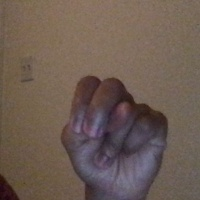

<IPython.core.display.Javascript object>

'NoneType' object has no attribute 'split'


<IPython.core.display.Javascript object>

In [ ]:
  # MAIN WHILE LOOP
run = True
while run:
  command = input("Enter 1 to do Sign Language, 2 to do Speech to Text and 3 to quit: ")
  if command == "1":
    doCamera() 
  elif command == "2":
    alreadyRan = False
    while alreadyRan == False:
      print('This is what you said: '+ speechToText())
      alreadyRan = True
  elif command == "3":
    print("QUITTING")
    run = False
  else:
    print("NOT A VALID COMMAND")